<a href="https://colab.research.google.com/github/t1p0kgod/DeepLearn/blob/main/work8/%D0%97%D0%BE%D0%BB%D0%BE%D1%82%D0%BA%D0%BE%D0%B2_%D0%A0%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_8_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Практическая работа №8. Генеративно-состязательная сеть (GAN). Часть 2**

[**Ссылка на код с пары**](https://colab.research.google.com/drive/1EjuztcsVONI_UWWTJYIVvREiDHGSxduE?usp=sharing)


[**Ссылка на техническую документацию**](https://www.tensorflow.org/tutorials/generative/pix2pix?hl=ru)

# Примечание:

Не забывайте периодически сохранять параметры модели. Функции для этого описаны в теоретической части. В случае приостановки процесса обучения из-за перегрузки ОЗУ, Вы сможете загрузить последние предобученные параметры и продолжить обучение.

# **Задание №1.** Обучите генератор воспризводить примитивные изображения по заданному условию (Conditional Generative Adversarial Nets (CGAN)). 

(На вход генератора подается вектор случайного шума и метка класса - на выходе должно получиться изображение, соответствующее данному классу)

Датасет выберите по желанию. ([Пример](https://www.kaggle.com/datasets/sagyamthapa/handwritten-math-symbols))

In [ ]:
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate

from matplotlib import pyplot as plt

In [ ]:
!pip install imutils

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import random
import pickle
import cv2
import os

In [ ]:
imagePaths = sorted(list(paths.list_images('/kaggle/input/animal-faces/afhq/train')))

In [ ]:
data = []
labels = []

In [ ]:
labels1 = []

In [ ]:
from ipywidgets import IntProgress, VBox, HTML
from IPython.display import display
import time

max_count = len(imagePaths);
f = IntProgress(min=0, max=max_count) 
counter = HTML()
box = VBox(children=[counter,f])
counter = f'{f.value}/{max_count}'

display(counter,f) 


for imagePath in imagePaths:
	image = cv2.imread(imagePath) 

	image = cv2.resize(image, (64, 64))
	data.append(image)

	label = imagePath.split(os.path.sep)[-2] 	
	labels.append(label) 
	f.value += 1 
# 	counter.value = f'{f.value}/{max_count}'

'0/14630'

IntProgress(value=0, max=14630)

In [ ]:
print(len(data))
print(len(data))

14630
14630


In [ ]:
data = np.array(data)

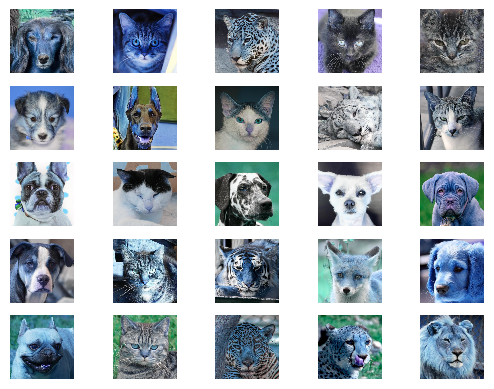

In [ ]:
trainX, trainy, testX, testy = train_test_split(data, labels,test_size=0.3,random_state=42)

# plot 25 images
for i in range(25):
	plt.subplot(5, 5, 1 + i)
	plt.axis('off')
	plt.imshow(trainX[i])
plt.show()

In [ ]:
set(testX)

{'cat', 'dog', 'wild'}

In [ ]:
def define_discriminator(in_shape=(64,64,3), n_classes=7):
	
    # Входная метка класса
	in_label = Input(shape=(1,))
    #Каждая метка (всего 10 классов для cifar) будет представлена вектором размера 50. 
    #Этот вектор размера 50 будет изучаться дискриминатором.
	li = Embedding(n_classes, 50)(in_label) #Shape = 1,50 (https://keras.io/api/layers/core_layers/embedding/)
	# масштабирование до размеров изображения
	n_nodes = in_shape[0] * in_shape[1]  #32x32 = 1024. 
	li = Dense(n_nodes)(li)  #Shape = 1, 1024
	# изменим форму с добавлением канала
	li = Reshape((in_shape[0], in_shape[1], 1))(li)  #32x32x1
    
    
	# Входное изображение
	in_image = Input(shape=in_shape) #32x32x3
  # Добавляем метку класса в качестве последнего канала
	merge = Concatenate()([in_image, li]) #32x32x4 (4 канала, 3 для изображения и четвертый для метки класса)
    
	# понижение дискретизации: Эта часть аналогична GAN из прошлой работы до выходного слоя.
  #Мы объединим входную метку с входным изображением и подадим их на вход модели. 	
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge) #16x16x128
	fe = LeakyReLU(alpha=0.2)(fe)
	# понижение дискретизации
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe) #8x8x128
	fe = LeakyReLU(alpha=0.2)(fe)
	# выровненная карта признаков
	fe = Flatten()(fe)  #8192  (8*8*128=8192)
	# dropout
	fe = Dropout(0.4)(fe)
	# output
	out_layer = Dense(1, activation='sigmoid')(fe)  #Shape=1
    
	# Комбинируем входную метку с входным изображением и подаем в качестве входных данных в модель.  
	model = Model([in_image, in_label], out_layer)
	# Компилируем модель
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

test_discr = define_discriminator()
print(test_discr.summary())

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_9 (Embedding)        (None, 1, 50)        350         ['input_23[0][0]']               
                                                                                                  
 dense_18 (Dense)               (None, 1, 4096)      208896      ['embedding_9[0][0]']            
                                                                                                  
 input_24 (InputLayer)          [(None, 64, 64, 3)]  0           []                               
                                                                                           

In [ ]:
def define_generator(latent_dim, n_classes=7):
    
	# Входная метка класса
	in_label = Input(shape=(1,))  #Вход размерности 1
	#Каждая метка (всего 10 классов для cifar), будет представлена вектором размером 50. 
	li = Embedding(n_classes, 50)(in_label) #Shape 1,50
    
	# линейное умножение
	n_nodes = 16 * 16  # Чтобы сопоставить размеры для конкатенации позже   
	li = Dense(n_nodes)(li) #1,64
	# изменим форму с добавлением канала
	li = Reshape((16, 16, 1))(li)
    
    
	# входной слой генератора изображений
	in_lat = Input(shape=(latent_dim,))  #Вход размером 100
    
	# Пусть базовое изображение будет иметь размерность 8x8
    # Для этого необходимо преобразовать входной латентный вектор в изображение 8x8. 
    #Таким образом, значение n_nodes для полносвязного слоя может быть 8192 (128*8*8) 
    # это позволит нам преобразовать его в "изображение" с размерностью 8x8x128
    # которое мы постепенно будем "увеличивать" до размерности 32x32х3 для вывода.
    #При определении входов модели мы объединим входную метку и латентный вход.

	n_nodes = 128 * 16 * 16
	gen = Dense(n_nodes)(in_lat)  #shape=8192
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((16, 16, 128))(gen) #Shape=8x8x128
	# объединяем входные данные изображения и соответствующей ему метки класса
	merge = Concatenate()([gen, li])  #Shape=8x8x129 (Дополнительный канал соответствующий метке класса)
	# увеличиваем дискретизацию до 16x16
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge) #16x16x128
	gen = LeakyReLU(alpha=0.2)(gen)
	# увеличиваем дискретизацию до to 32x32
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen) #32x32x128
	gen = LeakyReLU(alpha=0.2)(gen)
	# Выходной слой
	out_layer = Conv2D(3, (8,8), activation='tanh', padding='same')(gen) #32x32x3
  # определяем модель
	model = Model([in_lat, in_label], out_layer)
	return model   #Модель не компилируется, поскольку она не обучается напрямую, как дискриминатор.

test_gen = define_generator(100, n_classes=10)
print(test_gen.summary())


Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_26 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_25 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 dense_21 (Dense)               (None, 32768)        3309568     ['input_26[0][0]']               
                                                                                                  
 embedding_10 (Embedding)       (None, 1, 50)        500         ['input_25[0][0]']               
                                                                                           

In [ ]:
def define_gan(g_model, d_model):
  d_model.trainable = False  # Дискриминатор обучается отдельно, поэтому делаем его необучаемым.
    
    ## соединяем генератор и дискриминатор
	# сначала получаем входные данные - вектор шума и метки из модели генератора
  gen_noise, gen_label = g_model.input 
	# получение выходного изображения из модели генератора
  gen_output = g_model.output  #32x32x3
  print('gen_output',gen_output.shape) 
  # выходное изображение генератора и соответствующая входная метка являются входами для дискриминатора
  gan_output = d_model([gen_output, gen_label])
	# определим gan-модель как модель принимающую на вход вектор шума и метку класса (для генератора), и выдающую значение классификатора дискриминатора
  model = Model([gen_noise, gen_label], gan_output)

  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
def preprocess_labels(lab):
    encoded_lables  = encoder.fit_transform(lab)
    return encoded_lables

In [ ]:
# загружаем изображения из датасета cifar10

def load_real_samples():

	trainX, trainy = data, labels
	trainy = preprocess_labels(trainy)
	print(trainy.shape, trainX.shape)
	X = trainX.astype('float32')
	# нормализуем значения из начального диапазона [0,255] в диапазон [-1,1]
	X = (X - 127.5) / 127.5   # в генераторе используется функция активации tanh, поэтому изменяем масштаб 
               #исходных изображения в диапазон от -1 до 1.
	
	return [X, trainy]

In [ ]:
def generate_real_samples(dataset, n_samples):
	# разделяем изображения и метки
  images, labels = dataset  
	# выбираем случайные экземпляры
  ix = randint(0, images.shape[0], n_samples)
	# выбераем изображения и метки
  X, labels = images[ix], labels[ix]
  # генерируем метки классов и присваиваем их переменной y 
  #  (не путайте с вышеуказанными метками, которые соответствуют меткам cifar)	
  y = ones((n_samples, 1))  #Label=1 идентифицирует о том, что изображение реальное
  return [X, labels], y

In [ ]:
# Для генерации случайного шума используется функция, описанная выше 
def generate_fake_samples(generator, latent_dim, n_samples):
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	images = generator.predict([z_input, labels_input])
	y = zeros((n_samples, 1))  #Label=0 указывает на то, что они поддельные
	return [images, labels_input], y

In [ ]:
def generate_latent_points(latent_dim, n_samples, n_classes=7):
	x_input = randn(latent_dim * n_samples)
	z_input = x_input.reshape(n_samples, latent_dim)
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	half_batch = int(n_batch / 2)  #модель дискриминатора обновляется для половины партии реальных образцов 
                            #и половины партии поддельных образцов, объединенных в одну партию.  
	for i in range(n_epochs): 
		for j in range(bat_per_epo): 
			
      # Обучаем дискриминатор на реальных и поддельных изображениях, отдельно (по половине партии каждого).
      # Исследования показали, что раздельное обучение более эффективно. 

			[X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)

      # обновление весов модели дискриминатора
      # train_on_batch позволяет обновлять веса на основе коллекции предоставляемых образцов
			print('real_x_y',X_real.shape, labels_real.shape,y_real.shape)
			d_loss_real, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            
			# генерируем поддельные примеры
			[X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# обновляем веса модели дискриминатора
			d_loss_fake, _ = d_model.train_on_batch([X_fake, labels], y_fake)
            
            
			# генерация вектором случайного шума для нужного числа экземпляров в качестве входных данных для генератора
			[z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
            
        # Генератор хочет, чтобы дискриминатор пометил сгенерированные образцы
        # как истинные (единицы)
        # Здесь генератор пытается обмануть дискриминатор, чтобы тот поверил.
        # что сгенерированное изображение истинно (отсюда значение 1 для y)	
			  # поэтому для поддельных образцов мы создаём инвертированные метки 
			y_gan = ones((n_batch, 1))
   
        # Генератор является частью комбинированной модели, где он напрямую связан с дискриминатором.
        # Обучите генератор с latent_dim в качестве x и 1 в качестве y. 
        # Опять же, 1 в качестве выхода, так как он является состязательным, и если генератор отлично справился со своей задачей.
        # работу по следованию дискриминатору, то на выходе будет 1 (true)
			  # обновить генератор через ошибку дискриминатора
			
			g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
			# Выводим потери по этой партии
			print('Epoch>%d, Batch%d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))

In [ ]:
# Размерность вектора случайного шума
latent_dim = 100
# создание модели дискриминатора
d_model = define_discriminator()
# создание модели генератора
g_model = define_generator(latent_dim)
# создание комбинированной модели GAN
gan_model = define_gan(g_model, d_model)
# загрузка датасета
dataset = load_real_samples()

gen_output (None, 64, 64, 3)
(14630,) (14630, 64, 64, 3)


In [ ]:
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=10)

# сохранение обученной модели генератора (без возможности дообучения)


real_x_y (64, 64, 64, 3) (64,) (64, 1)
2/2 [==============================] - 0s 9ms/step
Epoch>1, Batch1/114, d1=0.331, d2=0.447 g=5.142
real_x_y (64, 64, 64, 3) (64,) (64, 1)
2/2 [==============================] - 0s 8ms/step
Epoch>1, Batch2/114, d1=0.346, d2=0.459 g=6.724
real_x_y (64, 64, 64, 3) (64,) (64, 1)
2/2 [==============================] - 0s 8ms/step
Epoch>1, Batch3/114, d1=0.387, d2=0.475 g=6.987
real_x_y (64, 64, 64, 3) (64,) (64, 1)
2/2 [==============================] - 0s 8ms/step
Epoch>1, Batch4/114, d1=0.365, d2=0.486 g=6.433
real_x_y (64, 64, 64, 3) (64,) (64, 1)
2/2 [==============================] - 0s 8ms/step
Epoch>1, Batch5/114, d1=0.368, d2=0.448 g=5.832
real_x_y (64, 64, 64, 3) (64,) (64, 1)
2/2 [==============================] - 0s 8ms/step
Epoch>1, Batch6/114, d1=0.348, d2=0.495 g=7.742
real_x_y (64, 64, 64, 3) (64,) (64, 1)
2/2 [==============================] - 0s 8ms/step
Epoch>1, Batch7/114, d1=0.347, d2=0.495 g=7.599
real_x_y (64, 64, 64, 3) (64,) (64

KeyboardInterrupt: 

In [ ]:
g_model.save('cgan_animals.h5')

In [ ]:

from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
import numpy as np
# 

In [ ]:
model = load_model('cgan_animals.h5')

### Демонстрация сгенерированных изображений:

1/1 [==============================] - 0s 20ms/step


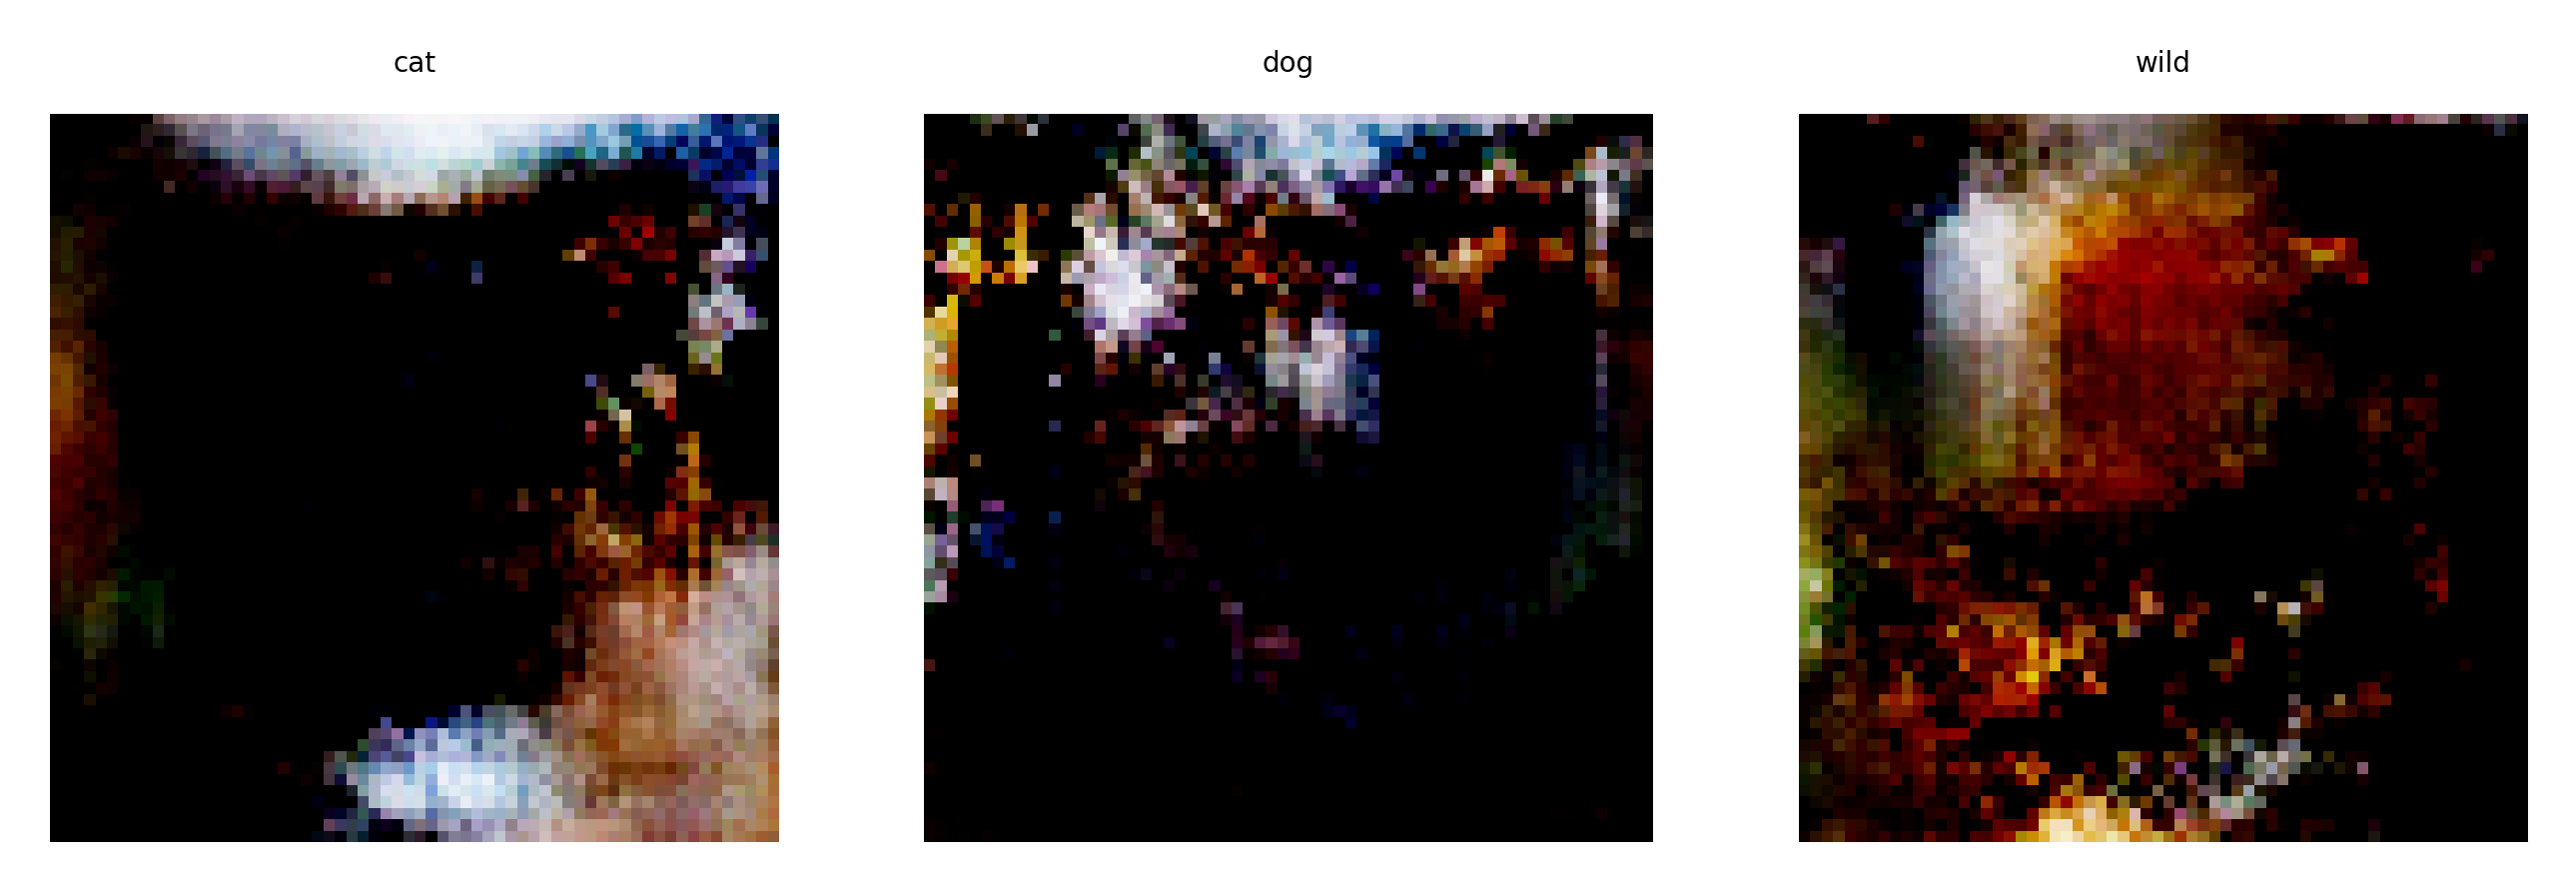

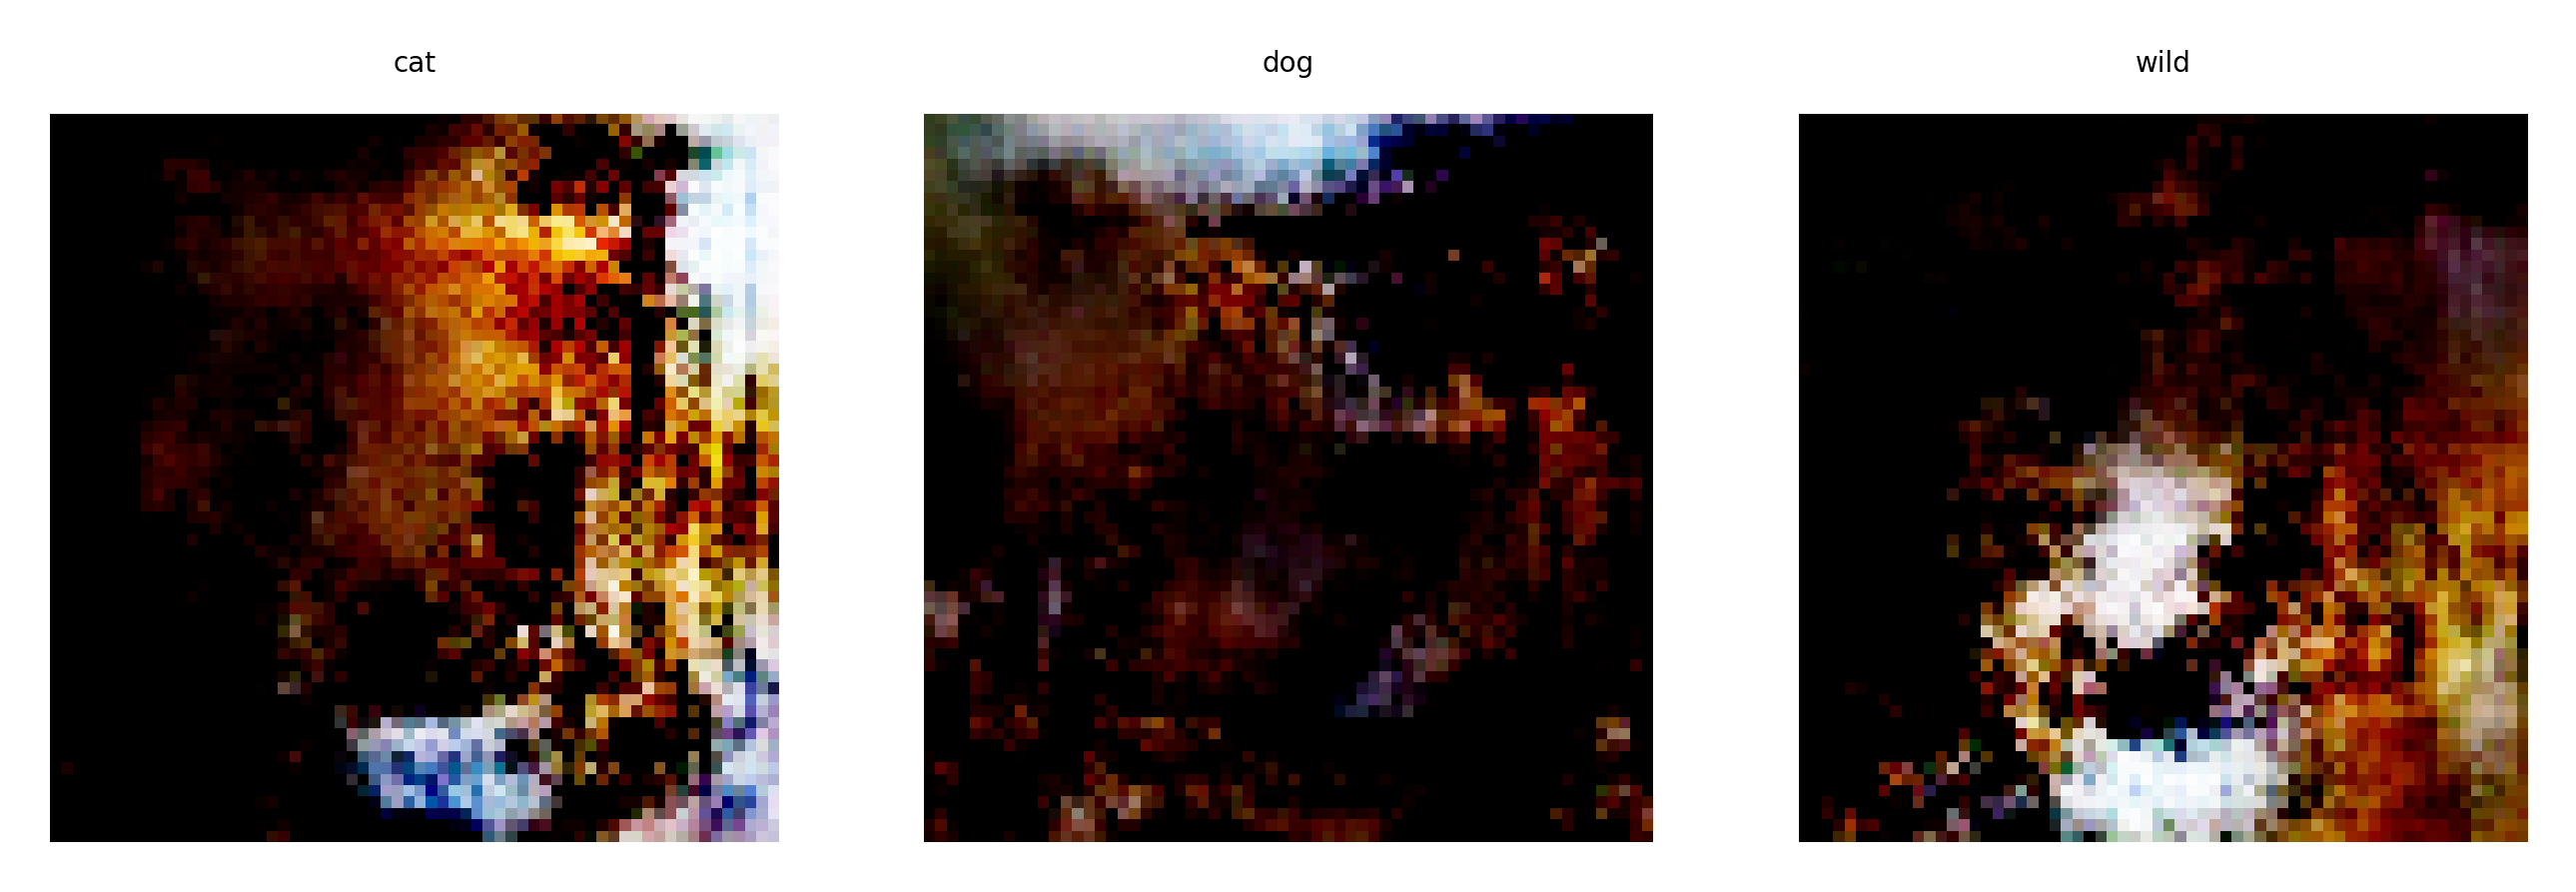

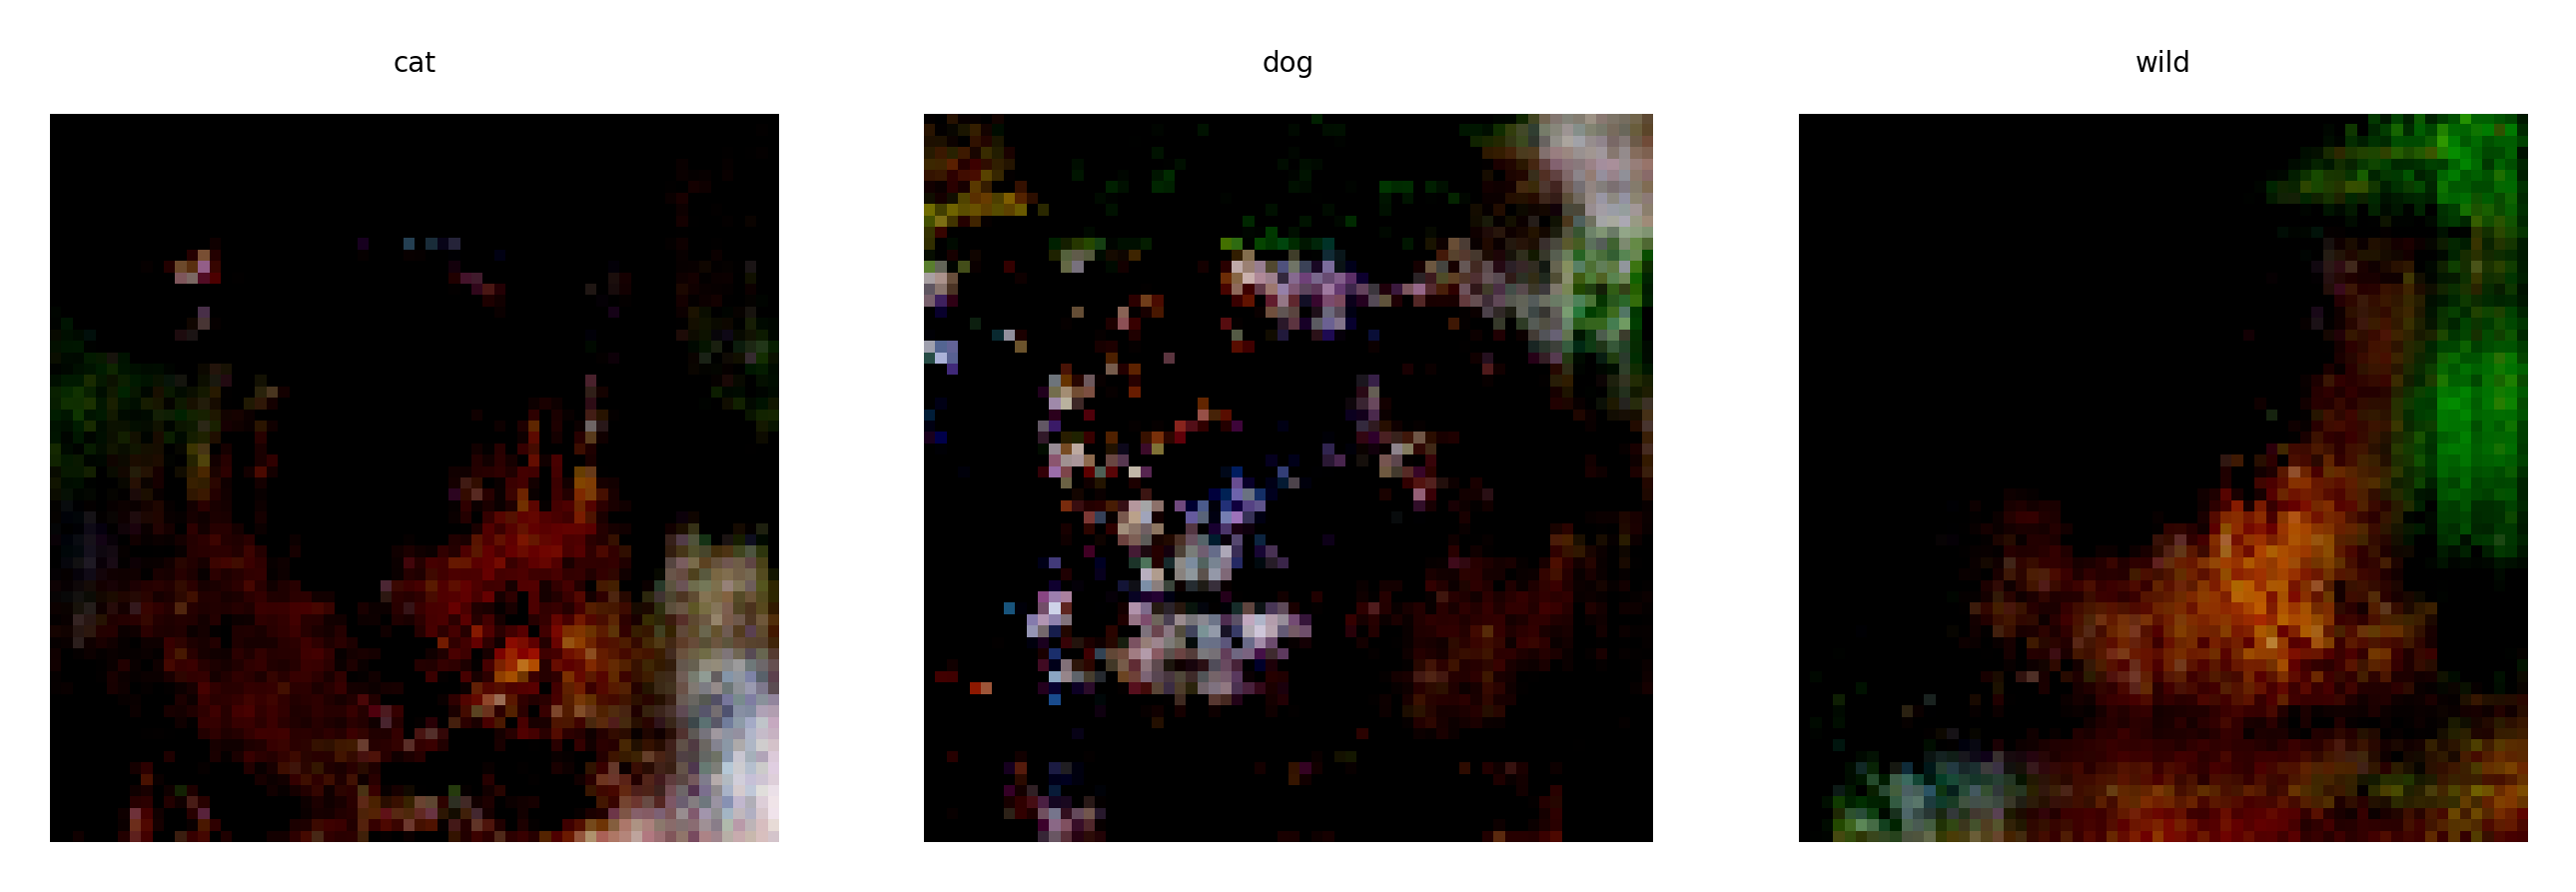

In [ ]:

# генерируем набор случайных векторов и меток классов
latent_points, rand_labels = generate_latent_points(100, 30)

# задаём метки классов - генерируем 10 наборов меток, 
# каждая из которых имеет значение от 0 до 9
rand_labels = asarray([x for _ in range(10) for x in range(3)])

# Генерируем изображения
X  = model.predict([latent_points, rand_labels])

# Преобразуем значения каждого пикселя в диапазон [0, 255] из диапазона [-1,1]
X = (X + 1) / 2.0
X = (X*255).astype(np.uint8)
# Генерируем изображения
X = g_model.predict([latent_points, rand_labels])
classes = {
    0:'cat',
    1:'dog',
    2:'wild',
          }

counter = 0
for i in range(3):
    fig, axs = plt.subplots(1, 3, dpi=500)
    for j in range(3):
        img = cv2.cvtColor(X[counter], cv2.COLOR_BGR2RGB)
        axs[j].imshow(img)
        axs[j].set_title(classes[j], fontsize=4)
        axs[j].axis('off')
        counter += 1	
    fig.show()

можно исплоьзовать символы или комиксы и т.д. на кеггле все есть

# **Задание №2.** Обучите генератор воспризводить **спутниковый снимок** по **загруженной маске** (pix2pix). Используйте для этого разделенный на патчи датасет из практической работы №7 ([Ссылка на датасет](https://www.kaggle.com/datasets/humansintheloop/semantic-segmentation-of-aerial-imagery))

In [ ]:
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model
import tensorflow as ts

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# root_dir = '/content/drive/MyDrive/DEEP LEARN ^_^/Semantic segmentation dataset/'

images_dir = '/content/drive/MyDrive/DEEP LEARN ^_^/dataset/train_image/train/'
masks_dir = '/content/drive/MyDrive/DEEP LEARN ^_^/dataset/train_mask/train/'

In [ ]:
def define_discriminator(image_shape):
    
	# инициализация веса
	init = RandomNormal(stddev=0.02) # Как описано в оригинальной статье
    
	# Входной слой для исходного изображения
	in_src_image = Input(shape=image_shape)  # Изображение, которое мы хотим преобразовать в другое изображение
       # Входной слой для целевого изображения
	in_target_image = Input(shape=image_shape)  # Изображение, которое мы хотим получить после обучения.
	
       # конкатенируем изображения по каналам
	merged = Concatenate()([in_src_image, in_target_image])
    
	# C64: 4x4 kernel Stride 2x2
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128: 4x4 kernel Stride 2x2
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256: 4x4 kernel Stride 2x2
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512: 4x4 kernel Stride 2x2. Этот блок кода добавлен самостоятельно, его нет в оригинальной статье. Закомментируйте его, если хотите.
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# последний выходной слой: 4x4 kernel but Stride 1x1
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# формирование патча
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# определяем модель
	model = Model([in_src_image, in_target_image], patch_out)

   #Модель обучается с размером партии в одно изображение, оптимизатором Adam с небольшой скоростью обучения и значением beta = 0.5.
    # Устанавливаем весовой коэффициент для дискриминатора в 50% (0.5) .
    
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

# disc_model = define_discriminator((256,256,3))
# plot_model(disc_model, to_file='disc_model.png', show_shapes=True)


In [ ]:
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# инициализируем вес
	init = RandomNormal(stddev=0.02)
       # добавим слой понижающей дискретизации
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
      # добавим опционально нормализацию батчей
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	g = LeakyReLU(alpha=0.2)(g)
	return g

In [ ]:
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# инициализируем вес
	init = RandomNormal(stddev=0.02)
	# добавим слой повышающей дискретизации
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# добавим нормализацию батчей
	g = BatchNormalization()(g, training=True)
	# опционально добавим дропаут
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# объединяем с пропуском соединения (skip connection)
	g = Concatenate()([g, skip_in])
	g = Activation('relu')(g)
	return g

In [ ]:
def define_generator(image_shape=(256,256,3)):
	# инициализация веса
	init = RandomNormal(stddev=0.02)
	# входной слой для изображения
	in_image = Input(shape=image_shape)
	# Архитектура энкодера: C64-C128-C256-C512-C512-C512-C512-C512
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# Архитектура декодера: CD512-CD512-CD512-C512-C256-C128-C64
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# Выходной слой
	g = Conv2DTranspose(image_shape[2], (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('tanh')(g)  #Генерируется изображение в диапазоне от -1 до 1.
	# Определяем модель
	model = Model(in_image, out_image)
	return model

# gen_model = define_generator((256,256,3))
# plot_model(gen_model, to_file='gen_model.png', show_shapes=True)

In [ ]:
# определяем комбинированную модель генератора и дискриминатора, для обновления генератора
def define_gan(g_model, d_model, image_shape):
	# делаем веса в дискриминаторе не обучаемыми
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False       #Слои дескриминатора установлены на необучаемые в комбинированной GAN, но
                                                # отдельный дескриминатор будет обучаемым.
            
	# определим входной слой для исходного изображения
	in_src = Input(shape=image_shape)
	# подаём изображение на вход генератора
	gen_out = g_model(in_src)
	# подаём входное изображения и сформированного изображения в качестве входных данных в дискриминатор
	dis_out = d_model([in_src, gen_out])
	# входное изображение в качестве входа, сгенерированное изображение и значение выходного слоя дискриминатора в качестве выходов
	model = Model(in_src, [dis_out, gen_out])
	opt = Adam(lr=0.0002, beta_1=0.5)
    
    #Общая потеря - это взвешенная сумма потерь от “состязательности” (Бинарная кросс-энтропия) и потери от MAE (L1).
    #Авторы предложили взвесить соотношение BCE и MAE как 1:100.
	model.compile(loss=['binary_crossentropy', 'mae'], 
               optimizer=opt, loss_weights=[1,100])
	return model

In [ ]:
def generate_real_samples(dataset, n_samples, patch_shape):
	# распаковка набора данных
	trainA, trainB = dataset
	# выбор случайных экземпляры
	ix = randint(0, trainA.shape[0], n_samples)
	# извлечение выбранных изображений
	X1, X2 = trainA[ix], trainB[ix]
	# генерация "реальных" меток классов (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

In [ ]:
def generate_fake_samples(g_model, samples, patch_shape):
	X = g_model.predict(samples)
	# генерация "поддельных" меток классов (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [ ]:
def summarize_performance(step, g_model, dataset, n_samples=3):
	# формирование выборки входных изображений
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	# генерация партии поддельных изображений
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# Нормализация
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0

	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + i)
		plt.axis('off')
		plt.imshow(X_realA[i])

	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples + i)
		plt.axis('off')
		plt.imshow(X_fakeB[i])

	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples*2 + i)
		plt.axis('off')
		plt.imshow(X_realB[i])

	filename1 = 'plot_%06d.png' % (step+1)
	plt.savefig(filename1)
	plt.close()

	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

In [ ]:
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
	# определение размерности выходного значения дискриминатора
	n_patch = d_model.output_shape[1]
	# распаковка датасета
	trainA, trainB = dataset
	# вычисление количества партий на одну эпоху обучения
	bat_per_epo = int(len(trainA) / n_batch)
	# вычисление количества тренировочных итераций
	n_steps = bat_per_epo * n_epochs
	for i in range(n_steps):
 		# формирование партии обучающей выборки (реальных образцов)
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		# генерация партии поддельных образцов
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		# обучение дискриминатора на реальных образцах
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		# обучение дискриминатора на «поддельных» образцах
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		# обучение генератора
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		# индикация процесса обучения
		print(f'Эпоха: {((i+1) // bat_per_epo) + 1}')
		print('Итерация: %d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		if (i+1) % (bat_per_epo * 1) == 0: # Сохраняем модель генератора и набор изображений каждую (1) эпоху. 
			summarize_performance(i, g_model, dataset)

In [ ]:
from os import listdir
from numpy import asarray, load
from numpy import vstack
from keras.utils import img_to_array
from keras.utils import load_img
from numpy import savez_compressed
from matplotlib import pyplot
import numpy as np

In [ ]:
def load_images(path, size=(256,256)):
  src_list = list()
  for filename in sorted(listdir(path)):
    image = load_img(path + filename, target_size=size)
    image = img_to_array(image)
		# разделение на спутниковый снимок и карту
		# sat_img, map_img = pixels[:, :256], pixels[:, 256:]
    src_list.append(image)
    # print(filename)
  return asarray(src_list)

In [ ]:
src_images = load_images(masks_dir)

In [ ]:
tar_images = load_images(images_dir)

In [ ]:
print('Загружено: ', src_images.shape, tar_images.shape)

Загружено:  (488, 256, 256, 3) (488, 256, 256, 3)


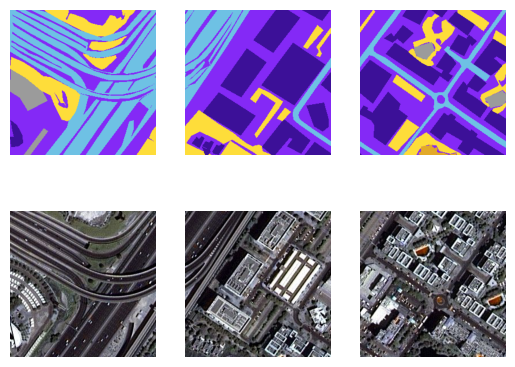

In [ ]:
n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(src_images[i].astype('uint8'))

for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(tar_images[i].astype('uint8'))
pyplot.show()

In [ ]:
data = [src_images, tar_images] # Формирование датасета

In [ ]:
def preprocess_data(data): 
	X1, X2 = data[0], data[1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

dataset = preprocess_data(data) # Предобработка исходного датасета

In [ ]:
image_shape = src_images.shape[1:] # определяем размерность входного слоя на основе загруженного набора данных

# определяем модели
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
gan_model = define_gan(g_model, d_model, image_shape)

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
image_shape

(256, 256, 3)

In [ ]:
from datetime import datetime 

start1 = datetime.now() 

train(d_model, g_model, gan_model, dataset, n_epochs=10, n_batch=1) 

stop1 = datetime.now()

# Время обучения модели
execution_time = stop1-start1
print("Время обучения модели: ", execution_time, f"(\nОдна эпоха: {(execution_time/10).total_seconds()/60} минут)")

1/1 [==============================] - 9s 9s/step
Эпоха: 1
Итерация: 1, d1[0.273] d2[1.056] g[70.179]
1/1 [==============================] - 0s 21ms/step
Эпоха: 1
Итерация: 2, d1[0.372] d2[0.761] g[51.396]
1/1 [==============================] - 0s 21ms/step
Эпоха: 1
Итерация: 3, d1[0.418] d2[0.704] g[47.610]
1/1 [==============================] - 0s 21ms/step
Эпоха: 1
Итерация: 4, d1[0.500] d2[0.908] g[54.291]
1/1 [==============================] - 0s 21ms/step
Эпоха: 1
Итерация: 5, d1[0.352] d2[0.642] g[64.693]
1/1 [==============================] - 0s 20ms/step
Эпоха: 1
Итерация: 6, d1[0.453] d2[0.585] g[42.209]
1/1 [==============================] - 0s 20ms/step
Эпоха: 1
Итерация: 7, d1[0.434] d2[0.461] g[62.282]
1/1 [==============================] - 0s 21ms/step
Эпоха: 1
Итерация: 8, d1[0.482] d2[0.501] g[45.724]
1/1 [==============================] - 0s 21ms/step
Эпоха: 1
Итерация: 9, d1[0.448] d2[0.480] g[44.806]
1/1 [==============================] - 0s 21ms/step
Эпоха: 1
Итера

KeyboardInterrupt: ignored

In [ ]:
print("Время обучения модели: ", execution_time, f"(\nОдна эпоха: {(execution_time/10).total_seconds()/60} минут)")

In [ ]:
g_model.save('pix2pix_aero.h5')

### Демонстрация сгенерированных изображений:

In [ ]:
from keras.models import load_model
from numpy.random import randint

In [ ]:
model = load_model('/content/drive/MyDrive/DEEP LEARN ^_^/pix2pix_aero.h5')

In [ ]:
# model = g_model

In [ ]:
# Визуализация исходных и сгенерированных изображений

def plot_images(src_img, gen_img, tar_img):
	images = vstack((src_img, gen_img, tar_img))
	images = (images + 1) / 2.0
	titles = ['Исходное', 'Сгенерированное', 'Ожидаемое']
	for i in range(len(images)):
		pyplot.subplot(1, 3, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(images[i])
		pyplot.title(titles[i])
	pyplot.show()

1/1 [==============================] - 0s 366ms/step


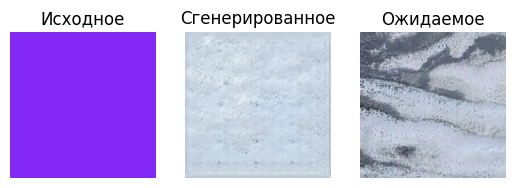

1/1 [==============================] - 0s 20ms/step


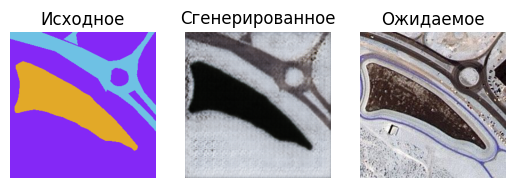

1/1 [==============================] - 0s 30ms/step


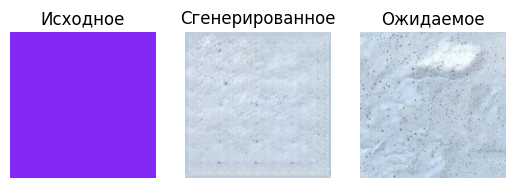

1/1 [==============================] - 0s 23ms/step


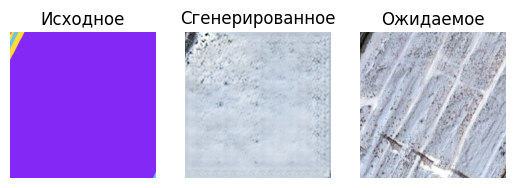

1/1 [==============================] - 0s 22ms/step


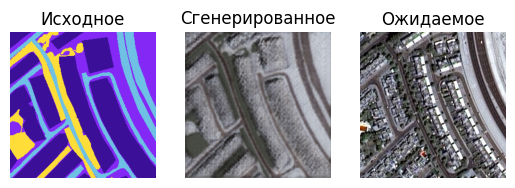

1/1 [==============================] - 0s 21ms/step


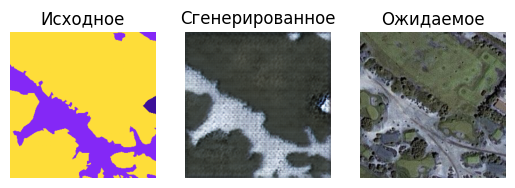

1/1 [==============================] - 0s 23ms/step


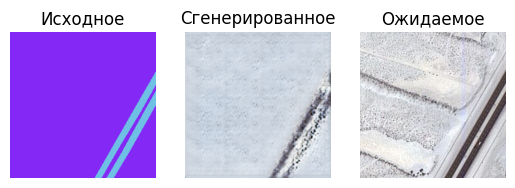

1/1 [==============================] - 0s 23ms/step


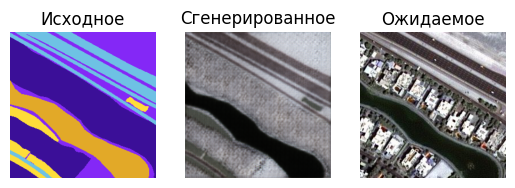

1/1 [==============================] - 0s 22ms/step


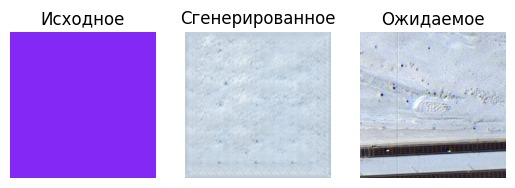

1/1 [==============================] - 0s 23ms/step


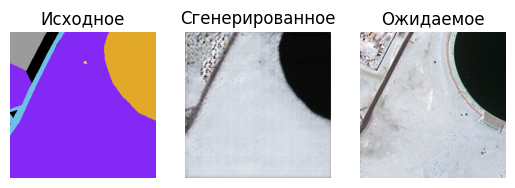

In [ ]:
[X1, X2] = dataset

for i in range(10):
  ix = randint(0, len(X1), 1) # выбираем случайные изображения
  src_image, tar_image = X1[ix], X2[ix]
  gen_image = model.predict(src_image) # генерируем целевое изображение (карту)
  plot_images(src_image, gen_image, tar_image) # Выводим оригинальное изображение, оригинальную карту и сгенерированную карту

# **Задание №3.** Обучите генератор воспроизводить изображения из выбранного Вами датасета (pix2pix). 

Датасет может быть сформирован Вами (например, черно-белые и цветные изображения) или найден в глобальной сети Интернет. 

Например [тут](https://www.kaggle.com/search?q=pix2pix+in%3Adatasets+datasetFileTypes%3Ajpg+datasetFileTypes%3Apng) или [тут](http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/)

In [ ]:
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model
import tensorflow as ts

In [ ]:

root_dir = '/kaggle/input/shoeset/ShoeSet/'


In [ ]:
def define_discriminator(image_shape):
    
	# инициализация веса
	init = RandomNormal(stddev=0.02) # Как описано в оригинальной статье
    
	# Входной слой для исходного изображения
	in_src_image = Input(shape=image_shape)  # Изображение, которое мы хотим преобразовать в другое изображение
       # Входной слой для целевого изображения
	in_target_image = Input(shape=image_shape)  # Изображение, которое мы хотим получить после обучения.
	
       # конкатенируем изображения по каналам
	merged = Concatenate()([in_src_image, in_target_image])
    
	# C64: 4x4 kernel Stride 2x2
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128: 4x4 kernel Stride 2x2
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256: 4x4 kernel Stride 2x2
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512: 4x4 kernel Stride 2x2. Этот блок кода добавлен самостоятельно, его нет в оригинальной статье. Закомментируйте его, если хотите.
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# последний выходной слой: 4x4 kernel but Stride 1x1
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# формирование патча
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# определяем модель
	model = Model([in_src_image, in_target_image], patch_out)

   #Модель обучается с размером партии в одно изображение, оптимизатором Adam с небольшой скоростью обучения и значением beta = 0.5.
    # Устанавливаем весовой коэффициент для дискриминатора в 50% (0.5) .
    
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

# disc_model = define_discriminator((256,256,3))
# plot_model(disc_model, to_file='disc_model.png', show_shapes=True)


In [ ]:
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# инициализируем вес
	init = RandomNormal(stddev=0.02)
       # добавим слой понижающей дискретизации
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
      # добавим опционально нормализацию батчей
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	g = LeakyReLU(alpha=0.2)(g)
	return g

In [ ]:
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# инициализируем вес
	init = RandomNormal(stddev=0.02)
	# добавим слой повышающей дискретизации
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# добавим нормализацию батчей
	g = BatchNormalization()(g, training=True)
	# опционально добавим дропаут
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# объединяем с пропуском соединения (skip connection)
	g = Concatenate()([g, skip_in])
	g = Activation('relu')(g)
	return g

In [ ]:
def define_generator(image_shape=(256,256,3)):
	# инициализация веса
	init = RandomNormal(stddev=0.02)
	# входной слой для изображения
	in_image = Input(shape=image_shape)
	# Архитектура энкодера: C64-C128-C256-C512-C512-C512-C512-C512
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# Архитектура декодера: CD512-CD512-CD512-C512-C256-C128-C64
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# Выходной слой
	g = Conv2DTranspose(image_shape[2], (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('tanh')(g)  #Генерируется изображение в диапазоне от -1 до 1.
	# Определяем модель
	model = Model(in_image, out_image)
	return model

# gen_model = define_generator((256,256,3))
# plot_model(gen_model, to_file='gen_model.png', show_shapes=True)

In [ ]:
# определяем комбинированную модель генератора и дискриминатора, для обновления генератора
def define_gan(g_model, d_model, image_shape):
	# делаем веса в дискриминаторе не обучаемыми
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False       #Слои дескриминатора установлены на необучаемые в комбинированной GAN, но
                                                # отдельный дескриминатор будет обучаемым.
            
	# определим входной слой для исходного изображения
	in_src = Input(shape=image_shape)
	# подаём изображение на вход генератора
	gen_out = g_model(in_src)
	# подаём входное изображения и сформированного изображения в качестве входных данных в дискриминатор
	dis_out = d_model([in_src, gen_out])
	# входное изображение в качестве входа, сгенерированное изображение и значение выходного слоя дискриминатора в качестве выходов
	model = Model(in_src, [dis_out, gen_out])
	opt = Adam(lr=0.0002, beta_1=0.5)
    
    #Общая потеря - это взвешенная сумма потерь от “состязательности” (Бинарная кросс-энтропия) и потери от MAE (L1).
    #Авторы предложили взвесить соотношение BCE и MAE как 1:100.
	model.compile(loss=['binary_crossentropy', 'mae'], 
               optimizer=opt, loss_weights=[1,100])
	return model

In [ ]:
def generate_real_samples(dataset, n_samples, patch_shape):
	# распаковка набора данных
	trainA, trainB = dataset
	# выбор случайных экземпляры
	ix = randint(0, trainA.shape[0], n_samples)
	# извлечение выбранных изображений
	X1, X2 = trainA[ix], trainB[ix]
	# генерация "реальных" меток классов (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

In [ ]:
def generate_fake_samples(g_model, samples, patch_shape):
	X = g_model.predict(samples)
	# генерация "поддельных" меток классов (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [ ]:
def summarize_performance(step, g_model, dataset, n_samples=3):
	# формирование выборки входных изображений
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	# генерация партии поддельных изображений
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# Нормализация
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0

	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + i)
		plt.axis('off')
		plt.imshow(X_realA[i])

	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples + i)
		plt.axis('off')
		plt.imshow(X_fakeB[i])

	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples*2 + i)
		plt.axis('off')
		plt.imshow(X_realB[i])

	filename1 = 'plot_%06d.png' % (step+1)
	plt.savefig(filename1)
	plt.close()

	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

In [ ]:
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
	# определение размерности выходного значения дискриминатора
	n_patch = d_model.output_shape[1]
	# распаковка датасета
	trainA, trainB = dataset
	# вычисление количества партий на одну эпоху обучения
	bat_per_epo = int(len(trainA) / n_batch)
	# вычисление количества тренировочных итераций
	n_steps = bat_per_epo * n_epochs
	for i in range(n_steps):
 		# формирование партии обучающей выборки (реальных образцов)
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		# генерация партии поддельных образцов
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		# обучение дискриминатора на реальных образцах
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		# обучение дискриминатора на «поддельных» образцах
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		# обучение генератора
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		# индикация процесса обучения
		print(f'Эпоха: {((i+1) // bat_per_epo) + 1}')
		print('Итерация: %d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		if (i+1) % (bat_per_epo * 1) == 0: # Сохраняем модель генератора и набор изображений каждую (1) эпоху. 
			summarize_performance(i, g_model, dataset)

In [ ]:
from os import listdir
from numpy import asarray, load
from numpy import vstack
from keras.utils import img_to_array
from keras.utils import load_img
from numpy import savez_compressed
from matplotlib import pyplot
import numpy as np

In [ ]:
def load_images(path, size=(256,512)):
	src_list, tar_list = list(), list()
	for filename in listdir(path):
		pixels = load_img(path + filename, target_size=size)
		pixels = img_to_array(pixels)
		# разделение на спутниковый снимок и карту
		sat_img, map_img = pixels[:, :256], pixels[:, 256:]
		src_list.append(sat_img)
		tar_list.append(map_img)
# 		print(filename)
	return [asarray(src_list), asarray(tar_list)]

In [ ]:
[src_images, tar_images] = load_images(root_dir)

In [ ]:
print('Загружено: ', src_images.shape, tar_images.shape)

Загружено:  (2000, 256, 256, 3) (2000, 256, 256, 3)


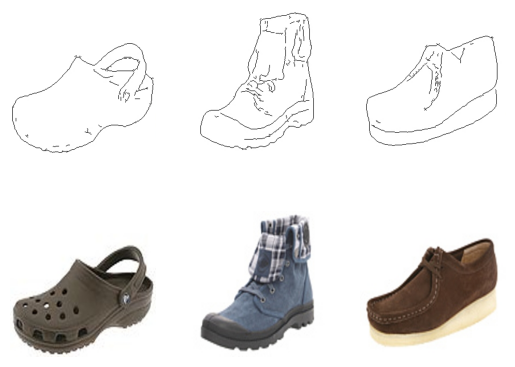

In [ ]:
n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(src_images[i].astype('uint8'))

for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(tar_images[i].astype('uint8'))
pyplot.show()

In [ ]:
data = [src_images, tar_images] # Формирование датасета

In [ ]:
def preprocess_data(data): 
	X1, X2 = data[0], data[1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

dataset = preprocess_data(data) # Предобработка исходного датасета

In [ ]:
image_shape = src_images.shape[1:] # определяем размерность входного слоя на основе загруженного набора данных

# определяем модели
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
gan_model = define_gan(g_model, d_model, image_shape)

/opt/conda/lib/python3.10/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
image_shape

(256, 256, 3)

In [ ]:
from datetime import datetime 

n_epochs = 5
start1 = datetime.now() 

train(d_model, g_model, gan_model, dataset, n_epochs=n_epochs, n_batch=1) 

stop1 = datetime.now()

# Время обучения модели
execution_time = stop1-start1
print("Время обучения модели: ", execution_time, f"(\nОдна эпоха: {(execution_time/n_epochs).total_seconds()/60} минут)")

2023-06-06 04:05:27.698513: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_12/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1/1 [==============================] - 1s 749ms/step


2023-06-06 04:05:31.016247: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_13/model_12/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


Эпоха: 1
Итерация: 1, d1[0.333] d2[0.822] g[89.876]
1/1 [==============================] - 0s 20ms/step
Эпоха: 1
Итерация: 2, d1[0.436] d2[0.755] g[87.355]
1/1 [==============================] - 0s 22ms/step
Эпоха: 1
Итерация: 3, d1[0.335] d2[0.568] g[87.821]
1/1 [==============================] - 0s 22ms/step
Эпоха: 1
Итерация: 4, d1[0.424] d2[0.468] g[80.432]
1/1 [==============================] - 0s 21ms/step
Эпоха: 1
Итерация: 5, d1[0.376] d2[0.410] g[79.761]
1/1 [==============================] - 0s 21ms/step
Эпоха: 1
Итерация: 6, d1[0.744] d2[0.648] g[71.376]
1/1 [==============================] - 0s 20ms/step
Эпоха: 1
Итерация: 7, d1[0.353] d2[0.371] g[71.455]
1/1 [==============================] - 0s 21ms/step
Эпоха: 1
Итерация: 8, d1[0.298] d2[0.370] g[69.186]
1/1 [==============================] - 0s 20ms/step
Эпоха: 1
Итерация: 9, d1[0.315] d2[0.289] g[63.274]
1/1 [==============================] - 0s 23ms/step
Эпоха: 1
Итерация: 10, d1[0.297] d2[0.236] g[71.359]
1/1 [======

KeyboardInterrupt: 

In [ ]:
print("Время обучения модели: ", execution_time, f"(\nОдна эпоха: {(execution_time/10).total_seconds()/60} минут)")

NameError: name 'execution_time' is not defined

In [ ]:
g_model.save('pix2pix_shoes.h5')

### Демонстрация сгенерированных изображений:

In [ ]:
from keras.models import load_model
from numpy.random import randint

In [ ]:
model = g_model

In [ ]:
# Визуализация исходных и сгенерированных изображений

def plot_images(src_img, gen_img, tar_img):
	images = vstack((src_img, gen_img, tar_img))
	images = (images + 1) / 2.0
	titles = ['Исходное', 'Сгенерированное', 'Ожидаемое']
	for i in range(len(images)):
		pyplot.subplot(1, 3, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(images[i])
		pyplot.title(titles[i])
	pyplot.show()

1/1 [==============================] - 0s 20ms/step


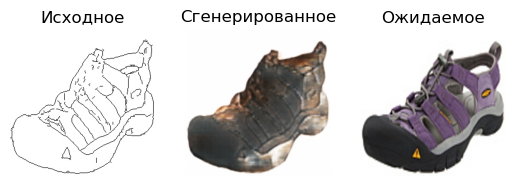

1/1 [==============================] - 0s 22ms/step


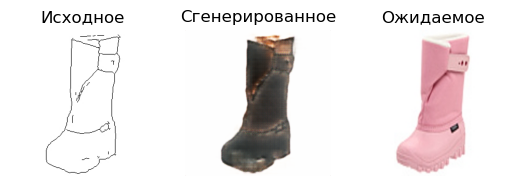

1/1 [==============================] - 0s 20ms/step


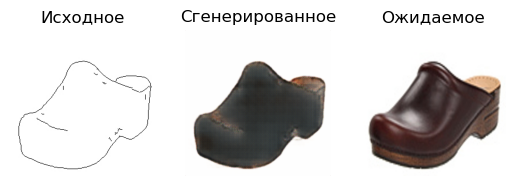

1/1 [==============================] - 0s 20ms/step


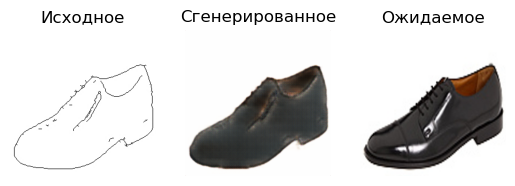

1/1 [==============================] - 0s 34ms/step


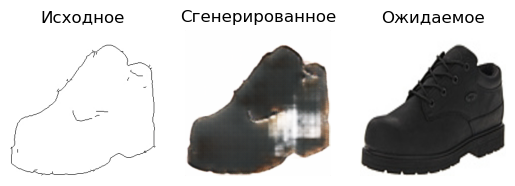

1/1 [==============================] - 0s 37ms/step


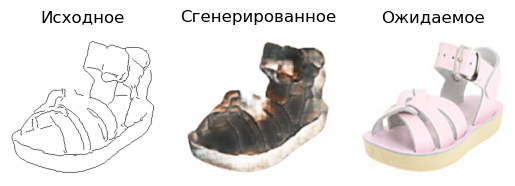

1/1 [==============================] - 0s 24ms/step


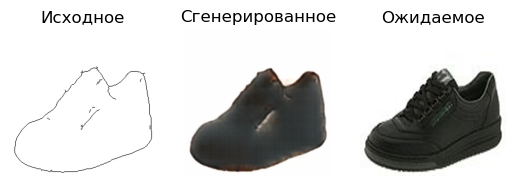

1/1 [==============================] - 0s 24ms/step


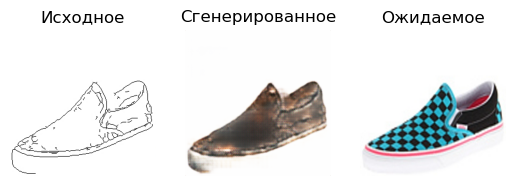

1/1 [==============================] - 0s 25ms/step


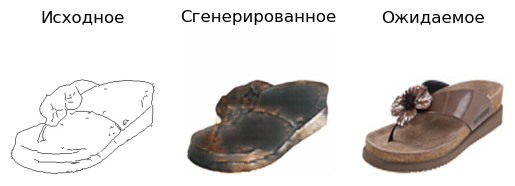

1/1 [==============================] - 0s 24ms/step


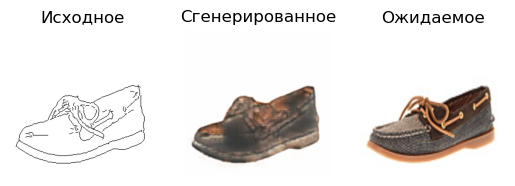

In [ ]:
[X1, X2] = dataset

for i in range(10):
  ix = randint(0, len(X1), 1) # выбираем случайные изображения
  src_image, tar_image = X1[ix], X2[ix]
  gen_image = model.predict(src_image) # генерируем целевое изображение (карту)
  plot_images(src_image, gen_image, tar_image) # Выводим оригинальное изображение, оригинальную карту и сгенерированную карту